# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://tip.duke.edu/independent_learning/greek/lesson/digging_deeper_final.jpg)



In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week1_intro/submit.py

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


state vector dim = 4
n_actions = 2


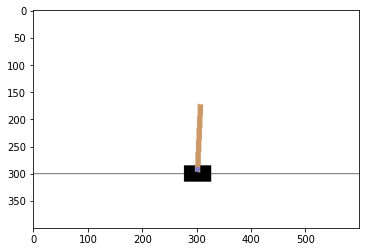

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probabilitity of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [3]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [4]:
def generate_session(agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])[0]

        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(np.arange(n_actions), p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [5]:
dummy_states, dummy_actions, dummy_reward = generate_session(agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[ 0.01928908 -0.03489641  0.04784377  0.04602736]
 [ 0.01859115 -0.2306706   0.04876432  0.35341331]
 [ 0.01397774 -0.03627476  0.05583259  0.0764972 ]
 [ 0.01325225 -0.23215081  0.05736253  0.38625971]
 [ 0.00860923 -0.42803817  0.06508773  0.69646279]]
actions: [0, 1, 0, 0, 0]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [26]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

#     <YOUR CODE: copy-paste your implementation from the previous notebook>
    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states, elite_actions = [], []
    for reward, states, actions in zip(rewards_batch, states_batch, actions_batch):
        if reward > reward_threshold:
            elite_states.extend(states)
            elite_actions.extend(actions)

    return elite_states, elite_actions        

# Training loop
Generate sessions, select N best and fit to those.

In [7]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = 197.490, threshold=224.700


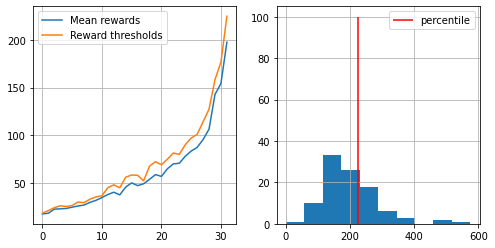

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [9]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session(agent) for i in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

#     <YOUR CODE: partial_fit agent to predict elite_actions(y) from elite_states(X)>
    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

# Results

In [10]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session(agent) for _ in range(100)]
env.close()

In [12]:
# show video
from IPython.display import HTML
import os

video_names = [
    s for s in os.listdir("./videos/")
    if s.endswith(".mp4")
]

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/" + video_names[-2]))  # this may or may not be the _last_ video. Try other indices

## Assignment: MountainCar

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

_if you have any trouble with CartPole-v0 and feel stuck, take a look at the forums_

Your assignment is to obtain average reward of __at least -150__ on `MountainCar-v0`.

See the tips section below, it's kinda important.
  
* Bonus quest: Devise a way to speed up training against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  
  
### Tips
* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

state vector dim = 2
n_actions = 3


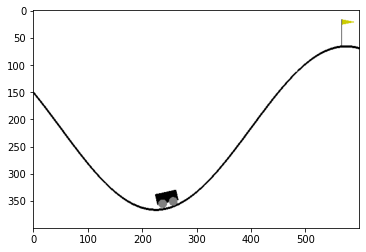

In [16]:
env = gym.wrappers.TimeLimit(gym.make("MountainCar-v0").env, 11000)
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

In [29]:
# YOUR CODE HERE
# (implement generate_session_mountain_car(), training loop, etc)
agent = MLPClassifier(
    hidden_layer_sizes=(30, 30, 30),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(30, 30, 30))

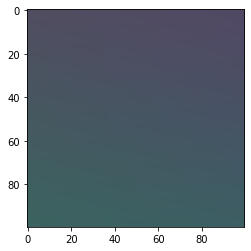

In [18]:
def visualize_mountain_car(env, agent):
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    grid = np.dstack(np.meshgrid(xs, vs)).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3)
    return probs

plt.imshow(visualize_mountain_car(env, agent))

In [24]:
def generate_session_mountain_car(agent, t_max=11000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])[0]

        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(np.arange(n_actions), p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

mean reward = -135.200, threshold=-110.000


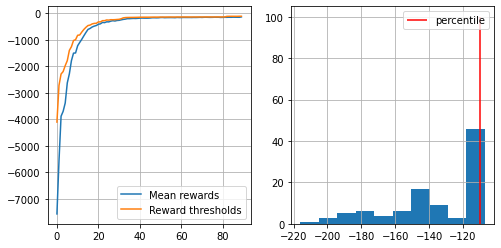

You Win! You may stop training now via KeyboardInterrupt.
90


KeyboardInterrupt: 

In [30]:
n_sessions = 100
percentile = 80
log = []

for i in range(100):
    print(i)
    # generate new sessions
    sessions = [generate_session_mountain_car(agent) for i in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

#     <YOUR CODE: partial_fit agent to predict elite_actions(y) from elite_states(X)>
    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch) - 10, np.max(rewards_batch)])

    if np.mean(rewards_batch) > - 145:
        print("You Win! You may stop training now via KeyboardInterrupt.")

In [32]:
def policy(obs, agent):
        probs = agent.predict_proba([obs])[0]

        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(np.arange(n_actions), p=probs)
        return a

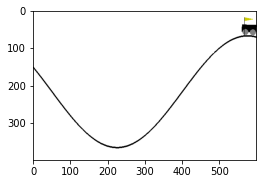

Well done!


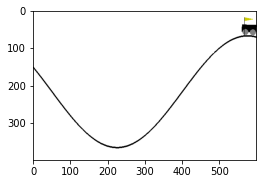

In [37]:
plt.figure(figsize=(4, 3))
clear_output(wait=True)

obs = env.reset()
for t in range(1000):
    plt.gca().clear()
    
    action = policy(obs, agent)  # Call your policy
    obs, reward, done, _ = env.step(action)  # Pass the action chosen by the policy to the environment
    
    # We don't do anything with reward here because MountainCar is a very simple environment,
    # and reward is a constant -1. Therefore, your goal is to end the episode as quickly as possible.

    # Draw game image on display.
    plt.imshow(env.render('rgb_array'))
    
    clear_output(wait=True)
    display(plt.gcf())

    if done:
        print("Well done!")
        break
else:
    print("Time limit exceeded. Try again.")

# clear_output(wait=True)

In [38]:
import joblib

joblib.dump(agent, 'mountain_car_agent.joblib')

['mountain_car_agent.joblib']

### Submit to Coursera

In [31]:
from submit import submit_mountain_car
submit_mountain_car(generate_session_mountain_car, agent, 'budylin@yandex.ru', '3fgmci9hXjJRaPgf')

Submitted to Coursera platform. See results on assignment page!
